In [34]:
#pip install --upgrade "protobuf<=3.20.1"

In [35]:
#necessary imports
import librosa
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import glob,os
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [36]:
random.seed(1)

In [37]:
# Extracting features from each .wav file
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [38]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)


In [39]:
#Emotions in the dataset
emotions={
  '01':'neutral',
  #'02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  #'07':'disgust',
  #'08':'surprised'
}

#Emotions to observe
#observed_emotions=['calm', 'happy', 'fearful', 'disgust', 'sad']


In [40]:
def get_features(path, isTraining):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Augmenting only training data and skipping augmentation for test data
    if isTraining:
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data, sample_rate)
        result = np.vstack((result, res2)) # stacking vertically

        # data with stretching 
        stretched_data = stretch(data)
        res3 = extract_features(stretched_data, sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        # data with pitch offset
        data_pitch = pitch(data, sample_rate)
        res4 = extract_features(data_pitch, sample_rate)
        result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [41]:
# Creating Dataframes
Ravdess = "data/"
ravdess_directory_list = os.listdir(Ravdess)
print(ravdess_directory_list)
file_emotion = []
file_path = []

for folder in glob.glob(f"{Ravdess}Actor_*"):
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(folder)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        if part[2] not in emotions.keys():
            continue
        file_emotion.append(int(part[2]))
        file_path.append(folder + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Mapping integers to corresponding emotions
Ravdess_df.Emotions.replace({1:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear'}, inplace=True)
Ravdess_df.head()

X, Y = Ravdess_df["Path"], Ravdess_df["Emotions"]

['Actor_02', 'Actor_03', 'Actor_22', 'Actor_08', 'Actor_16', 'Actor_20', 'Actor_04', 'Actor_19', 'Actor_15', 'Actor_17', 'Actor_07', 'Actor_24', 'Actor_12', 'Actor_21', 'Actor_01', 'Actor_13', 'Actor_11', 'Actor_18', 'Actor_23', 'Actor_05', 'Actor_14', 'Actor_10', 'Actor_06', 'Actor_09']


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [43]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(648,)
(648,)
(216,)
(216,)


In [44]:
X, Y = [], []
for path, emotion in zip(X_train, Y_train):
    feature = get_features(path, True)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have applied 4 augmentation techniques on each audio file
        Y.append(emotion)
x_train = X
y_train = Y

In [45]:
# Saving features in a csv file to avoid redundant feature extraction
Features = pd.DataFrame(x_train)
Features['labels'] = y_train
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.234756,0.453023,0.532435,0.675329,0.709075,0.575481,0.525318,0.548347,0.586336,0.646260,...,0.001135,0.000323,0.000474,0.000333,0.000373,0.000384,0.000303,0.000074,2.256767e-06,fear
1,0.325455,0.549621,0.574669,0.712600,0.773430,0.667388,0.619002,0.644139,0.666391,0.677656,...,0.002607,0.001992,0.002067,0.001923,0.002160,0.002005,0.001970,0.001701,1.525774e-03,fear
2,0.235400,0.467799,0.526148,0.696489,0.765350,0.596145,0.525455,0.554829,0.576128,0.608458,...,0.000454,0.000127,0.000189,0.000156,0.000179,0.000167,0.000103,0.000026,8.751683e-07,fear
3,0.244064,0.571490,0.473687,0.541058,0.732877,0.789297,0.602376,0.531433,0.564427,0.588936,...,0.000707,0.000806,0.000699,0.000248,0.000212,0.000182,0.000112,0.000044,5.921319e-07,fear
4,0.208771,0.471565,0.524938,0.570187,0.558178,0.477314,0.458931,0.627174,0.626698,0.669495,...,0.000595,0.001652,0.002122,0.000607,0.001908,0.001104,0.000152,0.000116,3.131501e-06,happy


In [46]:
x_train = Features.iloc[: ,:-1].values
y_train = Features['labels'].values
print(y_train)

['fear' 'fear' 'fear' ... 'happy' 'happy' 'happy']


In [47]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
print(y_train)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [48]:
X, Y = [], []
for path, emotion in zip(X_test, Y_test):
    feature = get_features(path, False)   
    X.append(feature)
    Y.append(emotion)

print(np.shape(X))
print(np.shape(Y))
x_test = np.array(X)
y_test = np.array(Y)


(216, 162)
(216,)


In [49]:
Y_test.head(5)

55       sad
316     fear
252     fear
262    angry
31       sad
Name: Emotions, dtype: object

In [50]:
X_test.head(5)

55     data/Actor_03/03-01-04-01-01-02-03.wav
316    data/Actor_15/03-01-06-02-01-02-15.wav
252    data/Actor_19/03-01-06-02-01-01-19.wav
262    data/Actor_19/03-01-05-01-02-02-19.wav
31     data/Actor_02/03-01-04-02-01-01-02.wav
Name: Path, dtype: object

In [51]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [52]:
# Normalization
scaler = sklearn.preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2592, 162), (2592, 5), (216, 162), (216, 5))

In [53]:
model1=MLPClassifier(alpha=0.01, batch_size=64, epsilon=1e-08, hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=500)
model1.fit(x_train,y_train)
score = model1.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.4351851851851852


In [54]:
# Reshaping train and test data for new model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2592, 162, 1), (2592, 5), (216, 162, 1), (216, 5))

# old model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [63]:
model = Sequential()
model.add(Conv1D(32, 8, padding='same',activation='relu', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()
# model = Sequential()
# model.add(Conv1D(256, 8, padding='same',activation='relu', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(Conv1D(256, 8, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 8, padding='same', activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(Conv1D(128, 8, padding='same',activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(64, 8, padding='same',activation='relu'))
# model.add(Conv1D(64, 8, padding='same',activation='relu'))
# model.add(Flatten())
# model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
# model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 162, 256)          2304      
                                                                 
 conv1d_33 (Conv1D)          (None, 162, 256)          524544    
                                                                 
 batch_normalization_8 (Batc  (None, 162, 256)         1024      
 hNormalization)                                                 
                                                                 


 dropout_8 (Dropout)         (None, 162, 256)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 20, 256)          0         
 1D)                                                             
                                                                 
 conv1d_34 (Conv1D)          (None, 20, 128)           262272    
                                                                 
 conv1d_35 (Conv1D)          (None, 20, 128)           131200    
                                                                 
 batch_normalization_9 (Batc  (None, 20, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 20, 128)           0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2, 128)           0         
 1D)      

In [64]:
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
history=model.fit(x_train, y_train, batch_size=32, epochs=65, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/45


648/648 [==============================] - 22s 31ms/step - loss: 1.4674 - accuracy: 0.3569 - val_loss: 1.4856 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 2/45
648/648 [==============================] - 20s 31ms/step - loss: 1.3526 - accuracy: 0.3978 - val_loss: 3.4028 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 3/45
648/648 [==============================] - 21s 32ms/step - loss: 1.3399 - accuracy: 0.4028 - val_loss: 1.4735 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 4/45
648/648 [==============================] - 20s 31ms/step - loss: 1.2300 - accuracy: 0.4599 - val_loss: 1.5764 - val_accuracy: 0.3565 - lr: 0.0010
Epoch 5/45
648/648 [==============================] - 20s 30ms/step - loss: 1.1832 - accuracy: 0.4830 - val_loss: 1.5093 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 6/45
648/648 [==============================] - 20s 30ms/step - loss: 1.1279 - accuracy: 0.5131 - val_loss: 1.4840 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 7/45
648/648 [==============================] - 19s 29ms/step -

In [65]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

7/7 [==============================] - 0s 27ms/step - loss: 4.3877 - accuracy: 0.5926
Accuracy of our model on test data :  59.25925970077515 %


In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)


7/7 [==============================] - 0s 32ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,happy,fear
2,happy,fear
3,angry,angry
4,neutral,sad
5,sad,sad
6,angry,angry
7,angry,fear
8,sad,sad
9,neutral,happy


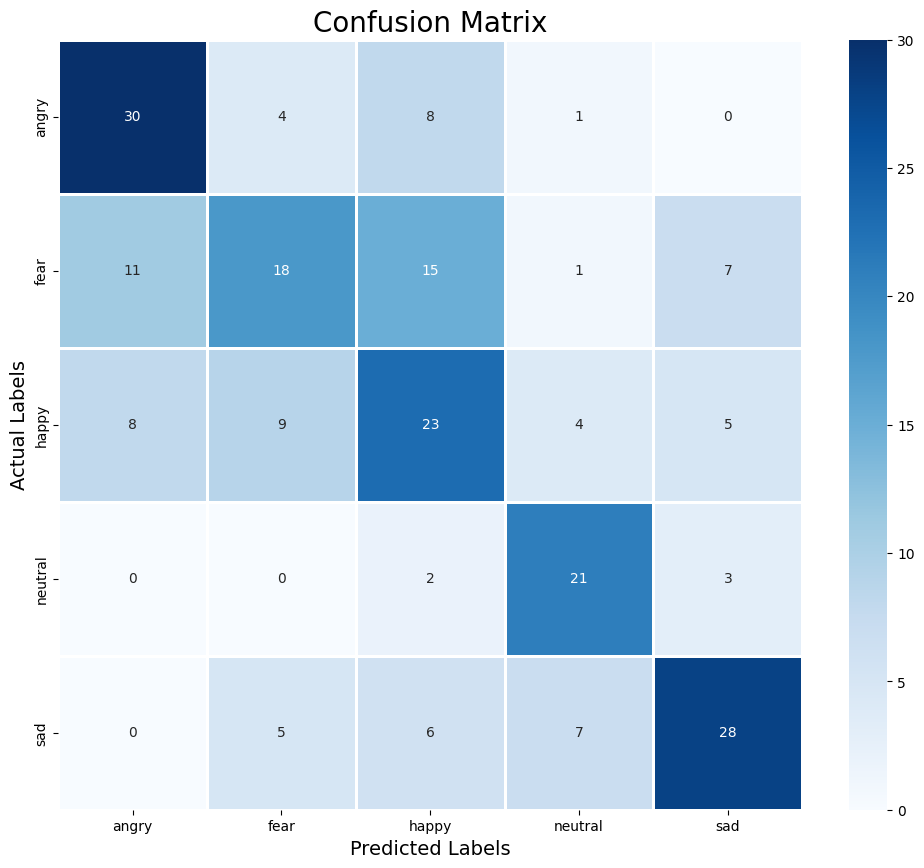

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.61      0.70      0.65        43
        fear       0.50      0.35      0.41        52
       happy       0.43      0.47      0.45        49
     neutral       0.62      0.81      0.70        26
         sad       0.65      0.61      0.63        46

    accuracy                           0.56       216
   macro avg       0.56      0.59      0.57       216
weighted avg       0.55      0.56      0.55       216



In [ ]:
# pip install tf2onnx

In [ ]:
import tf2onnx
import tensorflow as tf

onnx_model, _ = tf2onnx.convert.from_keras(model)
tf.io.write_graph(onnx_model, '.', 'model.onnx', as_text=False)

2023-07-30 03:13:49.014946: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-07-30 03:13:49.015138: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


2023-07-30 03:13:49.275038: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-07-30 03:13:49.275280: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


'./model.onnx'

In [ ]:
# Saved the current model to replicate results
#dump(model, open('model.pkl', 'wb'))

In [ ]:
from pickle import dump
dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
dump(encoder, open('encoder.pkl', 'wb'))

In [ ]:
input_name = onnx_model.graph.input[0].name
output_name = onnx_model.graph.output[0].name

print("Input node name:", input_name)
print("Output node name:", output_name)

Input node name: conv1d_input
Output node name: dense
